# SVM classification on the Breast Cancer

In [9]:
# SVM classification on the Breast Cancer dataset
# Author: Tomas Hobza

from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (balanced_accuracy_score, f1_score, 
                             precision_score, recall_score, accuracy_score,
                             confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import time

# set random seed for reproducibility
np.random.seed(42)

## 0. Load the dataset

In [10]:
## 0. Load the dataset

# Load the parquet files
df = pd.read_parquet('br_train_cleaned.parquet')

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['class'].value_counts())
print(f"\nClass balance ratio: {df['class'].value_counts().min() / df['class'].value_counts().max():.3f}")

# Display first few rows
print("\nFirst 5 rows:")
display(df.head())

# Check for missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")

Dataset shape: (285, 31)

Class distribution:
class
False    177
True     108
Name: count, dtype: int64

Class balance ratio: 0.610

First 5 rows:


,class,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,symmetryMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
ID,,,,,,,,,,,,,,,,,,,,,
8813129,False,13.27,17.02,84.55,546.4,0.08445,0.04994,0.03554,0.024560,0.1496,...,15.14,23.60,98.84,708.8,0.1276,0.1311,0.17860,0.09678,0.2506,0.07623
898678,False,12.06,18.90,76.66,445.3,0.08386,0.05794,0.00751,0.008488,0.1555,...,13.64,27.06,86.54,562.6,0.1289,0.1352,0.04506,0.05093,0.2880,0.08083
917896,False,13.71,18.68,88.73,571.0,0.09916,0.10700,0.05385,0.037830,0.1714,...,15.11,25.63,99.43,701.9,0.1425,0.2566,0.19350,0.12840,0.2849,0.09031
869691,True,11.80,16.58,78.99,432.0,0.10910,0.17000,0.16590,0.074150,0.2678,...,13.74,26.38,91.93,591.7,0.1385,0.4092,0.45040,0.18650,0.5774,0.10300
9110127,True,18.03,16.85,117.50,990.0,0.08947,0.12320,0.10900,0.062540,0.1720,...,20.38,22.02,133.30,1292.0,0.1263,0.2666,0.42900,0.15350,0.2842,0.08225



Missing values: 0


In [11]:
# Split the data into features and labels
X = df.drop(columns=['class'])
y = df['class']

# Split the data into training and testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set size: 228 samples
Test set size: 57 samples

Training set class distribution:
class
False    142
True      86
Name: count, dtype: int64

Test set class distribution:
class
False    35
True     22
Name: count, dtype: int64


## 1. Experiment - holdout vs cross-validation

In [12]:
# ============= FEATURE SCALING =============
print("\n" + "="*60)
print("FEATURE SCALING")
print("="*60)

# Check feature scales before scaling
print("\nFeature statistics BEFORE scaling (training set):")
print(X_train.describe().loc[['mean', 'std', 'min', 'max']].round(3))

# Initialize and fit scaler on TRAINING data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaling from training

# Convert back to DataFrame to maintain feature names (optional, for readability)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nFeature statistics AFTER scaling (training set):")
print(X_train_scaled.describe().loc[['mean', 'std', 'min', 'max']].round(3))

print("\n✓ Features scaled using StandardScaler (zero mean, unit variance)")
print("✓ Scaler fitted on training set only, then applied to test set")
print("="*60)

## 1. Experiment - holdout vs cross-validation

print("\n" + "="*60)
print("HOLDOUT VS CROSS-VALIDATION COMPARISON")
print("="*60)
print("Primary metric: F1 Score (weighted)")
print("="*60)

# == HOLDOUT APPROACH ==
print("\n[1/2] Training with holdout validation...")
model = LinearSVC(class_weight='balanced', max_iter=2000, random_state=42)
start = time.time()
model.fit(X_train_scaled, y_train)
holdout_time = time.time() - start

y_pred = model.predict(X_test_scaled)
holdout_f1 = f1_score(y_test, y_pred, average='binary')
holdout_bal_acc = balanced_accuracy_score(y_test, y_pred)

print(f"  Holdout F1 Score:         {holdout_f1:.4f}")
print(f"  Holdout Balanced Accuracy: {holdout_bal_acc:.4f}")
print(f"  Training time:             {holdout_time:.3f}s")

# == CROSS-VALIDATION APPROACH ==
print("\n[2/2] Training with 5-fold cross-validation...")
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

start = time.time()
# F1 Score (primary metric)
cv_scores_f1 = cross_val_score(
    LinearSVC(class_weight='balanced', max_iter=2000, random_state=42),
    X_train_scaled,
    y_train,
    cv=kf,
    scoring='f1',
    n_jobs=-1
)

# Balanced Accuracy (secondary metric)
cv_scores_bal_acc = cross_val_score(
    LinearSVC(class_weight='balanced', max_iter=2000, random_state=42),
    X_train_scaled,
    y_train,
    cv=kf,
    scoring='balanced_accuracy',
    n_jobs=-1
)
cv_time = time.time() - start

print(f"  CV F1 Score per fold:         {[f'{s:.4f}' for s in cv_scores_f1]}")
print(f"  CV F1 Mean:                   {cv_scores_f1.mean():.4f}")
print(f"  CV F1 Std:                    ±{cv_scores_f1.std():.4f}")
print(f"\n  CV Balanced Accuracy per fold: {[f'{s:.4f}' for s in cv_scores_bal_acc]}")
print(f"  CV Balanced Accuracy Mean:    {cv_scores_bal_acc.mean():.4f}")
print(f"  CV Balanced Accuracy Std:     ±{cv_scores_bal_acc.std():.4f}")
print(f"\n  Training time:                {cv_time:.3f}s ({cv_time/holdout_time:.1f}x longer)")

# Comparison
print("\n" + "="*60)
print("COMPARISON SUMMARY")
print("="*60)
print("F1 Score (Primary Metric):")
print(f"  Holdout:          {holdout_f1:.4f}")
print(f"  CV Mean:          {cv_scores_f1.mean():.4f}")
print(f"  Difference:       {abs(holdout_f1 - cv_scores_f1.mean()):.4f}")
print(f"  CV Std Dev:       ±{cv_scores_f1.std():.4f}")

print("\nBalanced Accuracy (Secondary Metric):")
print(f"  Holdout:          {holdout_bal_acc:.4f}")
print(f"  CV Mean:          {cv_scores_bal_acc.mean():.4f}")
print(f"  Difference:       {abs(holdout_bal_acc - cv_scores_bal_acc.mean()):.4f}")
print(f"  CV Std Dev:       ±{cv_scores_bal_acc.std():.4f}")

print("\nComputational Cost:")
print(f"  Holdout time:     {holdout_time:.3f}s")
print(f"  CV time:          {cv_time:.3f}s ({cv_time/holdout_time:.1f}x longer)")
print("="*60)


FEATURE SCALING

Feature statistics BEFORE scaling (training set):
      radiusMean   textureMean   perimeterMean   areaMean   smoothnessMean  \
mean      14.072        19.045          91.487    651.199            0.095   
std        3.548         4.569          24.412    348.664            0.013   
min        6.981        10.380          43.790    143.500            0.053   
max       27.420        39.280         186.900   2501.000            0.129   

       compactnessMean   concavityMean   concavePointsMean   symmetryMean  \
mean             0.100           0.085               0.048          0.183   
std              0.049           0.077               0.038          0.028   
min              0.019           0.000               0.000          0.122   
max              0.283           0.411               0.169          0.304   

       fractalDimensionMean  ...   radiusWorst   textureWorst  \
mean                  0.062  ...        16.227         25.523   
std                   0.0

After comparing holdout vs. cross-validation and finding CV provides more robust estimates, we proceeded with cross-validation for our parameter experiments as the dataset size is managable and it provides a better picutre of the model performances.

## 2. Experiment - C parameter

In [13]:
## 2. Experiment - C Parameter (using Cross-Validation on Training Set)

print("="*60)
print("HYPERPARAMETER TUNING: C PARAMETER")
print("="*60)
print("Using 5-fold cross-validation on TRAINING SET ONLY")
print("Using SCALED features\n")

# Test range of C values (regularization strength)
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
results_C = []

# Setup cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Testing C parameter values with CV on training set...")
for C in C_values:
    print(f"\n  C = {C}")
    model = LinearSVC(C=C, class_weight='balanced', max_iter=2000, random_state=42)
    
    # Cross-validation on TRAINING set only (SCALED)
    start = time.time()
    cv_scores_bal_acc = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='balanced_accuracy',
        n_jobs=-1
    )
    cv_scores_f1 = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='f1',  # Changed to f1_weighted for binary classification
        n_jobs=-1
    )
    cv_scores_precision = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='precision_weighted',
        n_jobs=-1
    )
    cv_scores_recall = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='recall_weighted',
        n_jobs=-1
    )
    cv_scores_acc = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='accuracy',
        n_jobs=-1
    )
    cv_time = time.time() - start
    
    results_C.append({
        'C': C,
        'cv_accuracy_mean': cv_scores_acc.mean(),
        'cv_accuracy_std': cv_scores_acc.std(),
        'cv_balanced_accuracy_mean': cv_scores_bal_acc.mean(),
        'cv_balanced_accuracy_std': cv_scores_bal_acc.std(),
        'cv_f1_mean': cv_scores_f1.mean(),
        'cv_f1_std': cv_scores_f1.std(),
        'cv_precision_mean': cv_scores_precision.mean(),
        'cv_precision_std': cv_scores_precision.std(),
        'cv_recall_mean': cv_scores_recall.mean(),
        'cv_recall_std': cv_scores_recall.std(),
        'cv_time': cv_time
    })
    
    print(f"    CV F1 Score (weighted):   {cv_scores_f1.mean():.4f} ± {cv_scores_f1.std():.4f}")
    print(f"    CV Balanced Accuracy:     {cv_scores_bal_acc.mean():.4f} ± {cv_scores_bal_acc.std():.4f}")
    print(f"    CV time: {cv_time:.3f}s")

# Convert to DataFrame for easier analysis
results_C_df = pd.DataFrame(results_C)
print("\n" + "="*60)
print("CROSS-VALIDATION RESULTS SUMMARY (on Training Set)")
print("="*60)
display(results_C_df)

# Find best C based on CV F1 score (primary metric)
best_C_idx_f1 = results_C_df['cv_f1_mean'].idxmax()
best_C = results_C_df.loc[best_C_idx_f1, 'C']
best_f1 = results_C_df.loc[best_C_idx_f1, 'cv_f1_mean']
best_f1_std = results_C_df.loc[best_C_idx_f1, 'cv_f1_std']
best_bal_acc = results_C_df.loc[best_C_idx_f1, 'cv_balanced_accuracy_mean']
best_bal_acc_std = results_C_df.loc[best_C_idx_f1, 'cv_balanced_accuracy_std']

print(f"\nBest C value (based on F1 Score): {best_C}")
print(f"CV F1 Score:          {best_f1:.4f} ± {best_f1_std:.4f}")
print(f"CV Balanced Accuracy: {best_bal_acc:.4f} ± {best_bal_acc_std:.4f}")

HYPERPARAMETER TUNING: C PARAMETER
Using 5-fold cross-validation on TRAINING SET ONLY
Using SCALED features

Testing C parameter values with CV on training set...

  C = 0.001
    CV F1 Score (weighted):   0.9654 ± 0.0279
    CV Balanced Accuracy:     0.9743 ± 0.0213
    CV time: 0.080s

  C = 0.01
    CV F1 Score (weighted):   0.9714 ± 0.0313
    CV Balanced Accuracy:     0.9778 ± 0.0236
    CV time: 0.076s

  C = 0.1
    CV F1 Score (weighted):   0.9714 ± 0.0313
    CV Balanced Accuracy:     0.9778 ± 0.0236
    CV time: 0.087s

  C = 1
    CV F1 Score (weighted):   0.9506 ± 0.0347
    CV Balanced Accuracy:     0.9637 ± 0.0226
    CV time: 0.092s

  C = 10
    CV F1 Score (weighted):   0.9545 ± 0.0212
    CV Balanced Accuracy:     0.9649 ± 0.0125
    CV time: 0.102s

  C = 100
    CV F1 Score (weighted):   0.9497 ± 0.0298
    CV Balanced Accuracy:     0.9614 ± 0.0179
    CV time: 0.079s

CROSS-VALIDATION RESULTS SUMMARY (on Training Set)


,C,cv_accuracy_mean,cv_accuracy_std,cv_balanced_accuracy_mean,cv_balanced_accuracy_std,cv_f1_mean,cv_f1_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_time
0,0.001,0.973720,0.021262,0.974319,0.021289,0.965368,0.027932,0.974689,0.020792,0.973720,0.021262,0.079882
1,0.010,0.978164,0.023815,0.977767,0.023643,0.971391,0.031316,0.978874,0.023217,0.978164,0.023815,0.076072
2,0.100,0.978164,0.023815,0.977767,0.023643,0.971391,0.031316,0.978874,0.023217,0.978164,0.023815,0.087292
3,1.000,0.960580,0.028814,0.963728,0.022596,0.950596,0.034713,0.964915,0.023526,0.960580,0.028814,0.092050
4,10.000,0.964928,0.017420,0.964865,0.012542,0.954492,0.021198,0.967411,0.014589,0.964928,0.017420,0.101931
5,100.000,0.960580,0.025322,0.961417,0.017868,0.949656,0.029782,0.964419,0.019630,0.960580,0.025322,0.079088



Best C value (based on F1 Score): 0.01
CV F1 Score:          0.9714 ± 0.0313
CV Balanced Accuracy: 0.9778 ± 0.0236


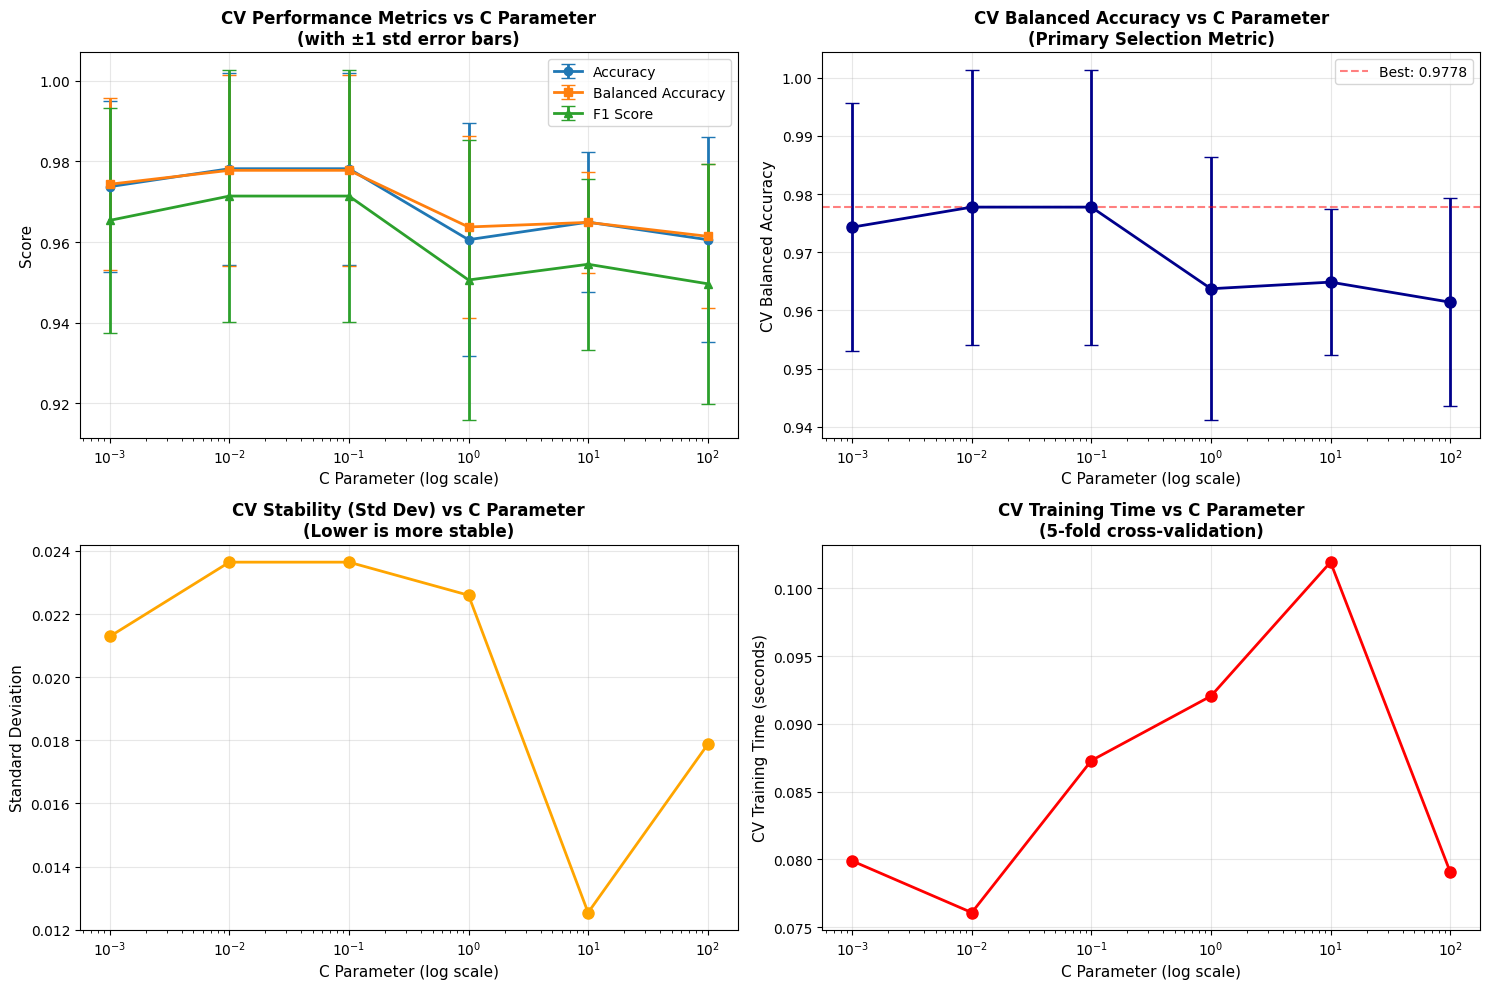

In [14]:
# Visualize C parameter impact
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Performance metrics vs C (with error bars)
ax1 = axes[0, 0]
ax1.errorbar(results_C_df['C'], results_C_df['cv_accuracy_mean'], 
             yerr=results_C_df['cv_accuracy_std'], 
             fmt='o-', label='Accuracy', linewidth=2, capsize=5)
ax1.errorbar(results_C_df['C'], results_C_df['cv_balanced_accuracy_mean'], 
             yerr=results_C_df['cv_balanced_accuracy_std'], 
             fmt='s-', label='Balanced Accuracy', linewidth=2, capsize=5)
ax1.errorbar(results_C_df['C'], results_C_df['cv_f1_mean'], 
             yerr=results_C_df['cv_f1_std'], 
             fmt='^-', label='F1 Score', linewidth=2, capsize=5)
ax1.set_xscale('log')
ax1.set_xlabel('C Parameter (log scale)', fontsize=11)
ax1.set_ylabel('Score', fontsize=11)
ax1.set_title('CV Performance Metrics vs C Parameter\n(with ±1 std error bars)', 
              fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Balanced Accuracy with tighter focus
ax2 = axes[0, 1]
ax2.errorbar(results_C_df['C'], results_C_df['cv_balanced_accuracy_mean'], 
             yerr=results_C_df['cv_balanced_accuracy_std'], 
             fmt='o-', color='darkblue', linewidth=2, capsize=5, markersize=8)
ax2.axhline(y=best_bal_acc, color='red', linestyle='--', alpha=0.5, 
            label=f'Best: {best_bal_acc:.4f}')
ax2.set_xscale('log')
ax2.set_xlabel('C Parameter (log scale)', fontsize=11)
ax2.set_ylabel('CV Balanced Accuracy', fontsize=11)
ax2.set_title('CV Balanced Accuracy vs C Parameter\n(Primary Selection Metric)', 
              fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Standard deviation (uncertainty) vs C
ax3 = axes[1, 0]
ax3.plot(results_C_df['C'], results_C_df['cv_balanced_accuracy_std'], 
         'o-', color='orange', linewidth=2, markersize=8)
ax3.set_xscale('log')
ax3.set_xlabel('C Parameter (log scale)', fontsize=11)
ax3.set_ylabel('Standard Deviation', fontsize=11)
ax3.set_title('CV Stability (Std Dev) vs C Parameter\n(Lower is more stable)', 
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: CV training time vs C
ax4 = axes[1, 1]
ax4.plot(results_C_df['C'], results_C_df['cv_time'], 
         'o-', color='red', linewidth=2, markersize=8)
ax4.set_xscale('log')
ax4.set_xlabel('C Parameter (log scale)', fontsize=11)
ax4.set_ylabel('CV Training Time (seconds)', fontsize=11)
ax4.set_title('CV Training Time vs C Parameter\n(5-fold cross-validation)', 
              fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Experiment - max_iter parameter

In [15]:
## 3. Experiment - max_iter Parameter (Convergence Analysis with CV)

print("="*60)
print("HYPERPARAMETER TUNING: MAX_ITER")
print("="*60)
print(f"Using best C value: {best_C}")
print("Testing max_iter values with 5-fold CV on training set...")
print("Using SCALED features\n")

max_iter_values = [500, 1000, 2000, 5000]
results_iter = []

# Setup cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for max_iter in max_iter_values:
    print(f"\n  max_iter = {max_iter}")
    model = LinearSVC(C=best_C, class_weight='balanced', max_iter=max_iter, random_state=42)
    
    # Cross-validation on training set (SCALED)
    start = time.time()
    cv_scores_bal_acc = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf,
        scoring='balanced_accuracy',
        n_jobs=-1
    )
    cv_scores_f1 = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf,
        scoring='f1',
        n_jobs=-1
    )
    cv_time = time.time() - start
    
    # Train once on full training set to check convergence (SCALED)
    model_check = LinearSVC(C=best_C, class_weight='balanced', max_iter=max_iter, random_state=42)
    model_check.fit(X_train_scaled, y_train)  # ← Using scaled data
    converged = model_check.n_iter_ < max_iter
    actual_iters = model_check.n_iter_
    
    results_iter.append({
        'max_iter': max_iter,
        'cv_balanced_accuracy_mean': cv_scores_bal_acc.mean(),
        'cv_balanced_accuracy_std': cv_scores_bal_acc.std(),
        'cv_f1_mean': cv_scores_f1.mean(),
        'cv_f1_std': cv_scores_f1.std(),
        'actual_iterations': actual_iters,
        'converged': converged,
        'cv_time': cv_time
    })
    
    print(f"    Converged: {converged} (used {actual_iters} iterations)")
    print(f"    CV F1 Score:          {cv_scores_f1.mean():.4f} ± {cv_scores_f1.std():.4f}")
    print(f"    CV Balanced Accuracy: {cv_scores_bal_acc.mean():.4f} ± {cv_scores_bal_acc.std():.4f}")
    print(f"    CV time: {cv_time:.3f}s")

results_iter_df = pd.DataFrame(results_iter)

print("\n" + "="*60)
print("CONVERGENCE ANALYSIS RESULTS")
print("="*60)
display(results_iter_df)

# Find best based on F1 score (primary metric)
best_iter_idx_f1 = results_iter_df['cv_f1_mean'].idxmax()
best_max_iter = results_iter_df.loc[best_iter_idx_f1, 'max_iter']

print(f"\nBest max_iter (based on F1 Score): {best_max_iter}")
print(f"CV F1 Score:          {results_iter_df.loc[best_iter_idx_f1, 'cv_f1_mean']:.4f}")
print(f"CV Balanced Accuracy: {results_iter_df.loc[best_iter_idx_f1, 'cv_balanced_accuracy_mean']:.4f}")
print(f"All models converged: {results_iter_df['converged'].all()}")

HYPERPARAMETER TUNING: MAX_ITER
Using best C value: 0.01
Testing max_iter values with 5-fold CV on training set...
Using SCALED features


  max_iter = 500
    Converged: True (used 6 iterations)
    CV F1 Score:          0.9714 ± 0.0313
    CV Balanced Accuracy: 0.9778 ± 0.0236
    CV time: 0.047s

  max_iter = 1000
    Converged: True (used 6 iterations)
    CV F1 Score:          0.9714 ± 0.0313
    CV Balanced Accuracy: 0.9778 ± 0.0236
    CV time: 0.026s

  max_iter = 2000
    Converged: True (used 6 iterations)
    CV F1 Score:          0.9714 ± 0.0313
    CV Balanced Accuracy: 0.9778 ± 0.0236
    CV time: 0.028s

  max_iter = 5000
    Converged: True (used 6 iterations)
    CV F1 Score:          0.9714 ± 0.0313
    CV Balanced Accuracy: 0.9778 ± 0.0236
    CV time: 0.028s

CONVERGENCE ANALYSIS RESULTS


,max_iter,cv_balanced_accuracy_mean,cv_balanced_accuracy_std,cv_f1_mean,cv_f1_std,actual_iterations,converged,cv_time
0,500,0.977767,0.023643,0.971391,0.031316,6,True,0.047261
1,1000,0.977767,0.023643,0.971391,0.031316,6,True,0.026280
2,2000,0.977767,0.023643,0.971391,0.031316,6,True,0.027776
3,5000,0.977767,0.023643,0.971391,0.031316,6,True,0.027652



Best max_iter (based on F1 Score): 500
CV F1 Score:          0.9714
CV Balanced Accuracy: 0.9778
All models converged: True


## Final Model Evaluation

FINAL MODEL EVALUATION ON TEST SET
Using best hyperparameters from CV:
  C = 0.01
  max_iter = 500
  Using SCALED features

Classification type: Binary
Number of training samples: 228
Number of test samples: 57

Training final model on entire training set...
Training completed in 0.0013s
Converged: True (used 6 iterations)

Evaluating on test set...
Prediction completed in 0.0006s

TEST SET PERFORMANCE (Unbiased Estimate)
  F1 Score (binary):     0.9302  ← Primary Metric
  Precision (binary):    0.9524
  Recall (binary):       0.9091
  Accuracy:              0.9474

EFFICIENCY METRICS
  Training time:         0.0013s
  Test time:             0.0006s
  Total time:            0.0020s
  Training samples:      228
  Test samples:          57
  Time per train sample: 0.0059ms
  Time per test sample:  0.0109ms

CV TRAINING vs TEST SET COMPARISON
F1 Score:
  CV (training):  0.9714 ± 0.0313
  Test:           0.9302
  Difference:     0.0412

Balanced Accuracy:
  CV (training):  0.9778 ± 0.0236


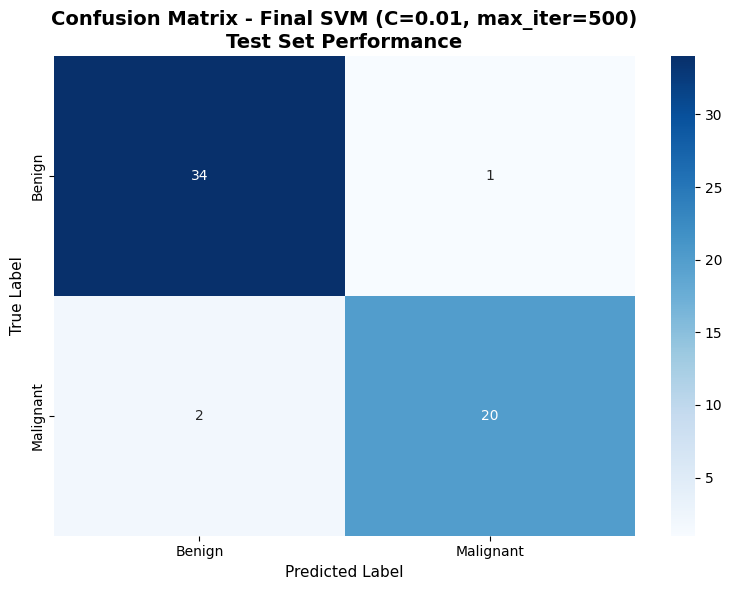


Confusion Matrix Breakdown:
  True Negatives (TN):   34 - Correctly identified benign
  False Positives (FP):   1 - Benign misclassified as malignant
  False Negatives (FN):   2 - Malignant misclassified as benign ⚠
  True Positives (TP):   20 - Correctly identified malignant

Additional Clinical Metrics:
  Specificity (True Negative Rate): 0.9714 - correctly identify benign
  Sensitivity (True Positive Rate): 0.9091 - correctly identify malignant
  False Negative Rate:              0.0909 ← Critical for cancer diagnosis
  False Positive Rate:              0.0286

FINAL MODEL SUMMARY
Model: LinearSVC
Task: Binary classification
Hyperparameters: C=0.01, max_iter=500, class_weight='balanced'
Preprocessing: StandardScaler (zero mean, unit variance)
Convergence: 6 iterations

PERFORMANCE METRICS:
  F1 Score (binary):     0.9302
  Precision (binary):    0.9524
  Recall (binary):       0.9091
  Accuracy:              0.9474

EFFICIENCY METRICS:
  Training time:         0.0013s
  Test time: 

,0
Model,LinearSVC
Classification Type,Binary
F1 Score,0.930233
Precision,0.952381
Recall,0.909091
Accuracy,0.947368
Train Time (s),0.001347
Test Time (s),0.000623
Training Samples,228
Test Samples,57


In [16]:
## 4. Final Model Evaluation on Test Set

print("="*60)
print("FINAL MODEL EVALUATION ON TEST SET")
print("="*60)
print(f"Using best hyperparameters from CV:")
print(f"  C = {best_C}")
print(f"  max_iter = {best_max_iter}")
print(f"  Using SCALED features")
print()

# Determine if binary or multi-class classification
n_classes = len(y.unique())
is_binary = n_classes == 2
print(f"Classification type: {'Binary' if is_binary else f'Multi-class ({n_classes} classes)'}")
print(f"Number of training samples: {len(X_train_scaled)}")
print(f"Number of test samples: {len(X_test_scaled)}")
print()

# Train final model with best hyperparameters on SCALED training data
final_model = LinearSVC(C=best_C, class_weight='balanced', max_iter=best_max_iter, random_state=42)

print("Training final model on entire training set...")
train_start = time.time()
final_model.fit(X_train_scaled, y_train)  # ← Using scaled data
train_time = time.time() - train_start

print(f"Training completed in {train_time:.4f}s")
print(f"Converged: {final_model.n_iter_ < best_max_iter} (used {final_model.n_iter_} iterations)")

# Predictions on test set (SCALED)
print("\nEvaluating on test set...")
test_start = time.time()
y_pred_final = final_model.predict(X_test_scaled)  # ← Using scaled data
test_time = time.time() - test_start

print(f"Prediction completed in {test_time:.4f}s")

# Comprehensive metrics - using appropriate averaging based on classification type
if is_binary:
    # Binary classification - use 'binary' averaging
    test_f1 = f1_score(y_test, y_pred_final, average='binary')
    test_precision = precision_score(y_test, y_pred_final, average='binary')
    test_recall = recall_score(y_test, y_pred_final, average='binary')
    metric_type = "binary"
else:
    # Multi-class classification - use 'macro' averaging
    test_f1 = f1_score(y_test, y_pred_final, average='macro')
    test_precision = precision_score(y_test, y_pred_final, average='macro')
    test_recall = recall_score(y_test, y_pred_final, average='macro')
    metric_type = "macro"

test_acc = accuracy_score(y_test, y_pred_final)

print("\n" + "="*60)
print("TEST SET PERFORMANCE (Unbiased Estimate)")
print("="*60)
print(f"  F1 Score ({metric_type}):     {test_f1:.4f}  ← Primary Metric")
print(f"  Precision ({metric_type}):    {test_precision:.4f}")
print(f"  Recall ({metric_type}):       {test_recall:.4f}")
print(f"  Accuracy:              {test_acc:.4f}")
print()
print("EFFICIENCY METRICS")
print("="*60)
print(f"  Training time:         {train_time:.4f}s")
print(f"  Test time:             {test_time:.4f}s")
print(f"  Total time:            {train_time + test_time:.4f}s")
print(f"  Training samples:      {len(X_train_scaled)}")
print(f"  Test samples:          {len(X_test_scaled)}")
print(f"  Time per train sample: {train_time/len(X_train_scaled)*1000:.4f}ms")
print(f"  Time per test sample:  {test_time/len(X_test_scaled)*1000:.4f}ms")

# Compare CV training performance vs test performance
print("\n" + "="*60)
print("CV TRAINING vs TEST SET COMPARISON")
print("="*60)
cv_best_f1 = results_C_df.loc[best_C_idx_f1, 'cv_f1_mean']
cv_best_f1_std = results_C_df.loc[best_C_idx_f1, 'cv_f1_std']
cv_best_bal_acc = results_C_df.loc[best_C_idx_f1, 'cv_balanced_accuracy_mean']
cv_best_bal_acc_std = results_C_df.loc[best_C_idx_f1, 'cv_balanced_accuracy_std']

print(f"F1 Score:")
print(f"  CV (training):  {cv_best_f1:.4f} ± {cv_best_f1_std:.4f}")
print(f"  Test:           {test_f1:.4f}")
print(f"  Difference:     {abs(cv_best_f1 - test_f1):.4f}")

print(f"\nBalanced Accuracy:")
print(f"  CV (training):  {cv_best_bal_acc:.4f} ± {cv_best_bal_acc_std:.4f}")

# Interpretation
if abs(cv_best_f1 - test_f1) < cv_best_f1_std:
    print("\n✓ Test F1 score is within CV std dev → Good generalization!")
else:
    print("\n⚠ Test F1 score differs from CV estimate → Check for overfitting/dataset shift")

print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
# Get class names if available, otherwise use default labels
class_names = ['Benign (False)', 'Malignant (True)'] if len(y.unique()) == 2 else None
print(classification_report(y_test, y_pred_final, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Benign', 'Malignant'] if len(y.unique()) == 2 else None,
            yticklabels=['Benign', 'Malignant'] if len(y.unique()) == 2 else None)
plt.title(f'Confusion Matrix - Final SVM (C={best_C}, max_iter={best_max_iter})\nTest Set Performance', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=11)
plt.xlabel('Predicted Label', fontsize=11)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN):  {cm[0,0]:3d} - Correctly identified benign")
print(f"  False Positives (FP): {cm[0,1]:3d} - Benign misclassified as malignant")
print(f"  False Negatives (FN): {cm[1,0]:3d} - Malignant misclassified as benign ⚠")
print(f"  True Positives (TP):  {cm[1,1]:3d} - Correctly identified malignant")

# Calculate per-class metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)  # Same as recall for positive class

print(f"\nAdditional Clinical Metrics:")
print(f"  Specificity (True Negative Rate): {specificity:.4f} - correctly identify benign")
print(f"  Sensitivity (True Positive Rate): {sensitivity:.4f} - correctly identify malignant")
print(f"  False Negative Rate:              {fn/(fn+tp):.4f} ← Critical for cancer diagnosis")
print(f"  False Positive Rate:              {fp/(fp+tn):.4f}")

print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"Model: LinearSVC")
print(f"Task: {'Binary' if is_binary else 'Multi-class'} classification")
print(f"Hyperparameters: C={best_C}, max_iter={best_max_iter}, class_weight='balanced'")
print(f"Preprocessing: StandardScaler (zero mean, unit variance)")
print(f"Convergence: {final_model.n_iter_} iterations")
print()
print("PERFORMANCE METRICS:")
print(f"  F1 Score ({metric_type}):     {test_f1:.4f}")
print(f"  Precision ({metric_type}):    {test_precision:.4f}")
print(f"  Recall ({metric_type}):       {test_recall:.4f}")
print(f"  Accuracy:              {test_acc:.4f}")
print()
print("EFFICIENCY METRICS:")
print(f"  Training time:         {train_time:.4f}s")
print(f"  Test time:             {test_time:.4f}s")
print(f"  Training samples:      {len(X_train_scaled)}")
print(f"  Test samples:          {len(X_test_scaled)}")
print("="*60)

# Create summary dictionary for easy reference
final_results = {
    'Model': 'LinearSVC',
    'Classification Type': 'Binary' if is_binary else 'Multi-class',
    'F1 Score': test_f1,
    'Precision': test_precision,
    'Recall': test_recall,
    'Accuracy': test_acc,
    'Train Time (s)': train_time,
    'Test Time (s)': test_time,
    'Training Samples': len(X_train_scaled),
    'Test Samples': len(X_test_scaled),
    'C': best_C,
    'max_iter': best_max_iter,
    'Convergence Iterations': final_model.n_iter_
}

print("\n" + "="*60)
print("RESULTS SUMMARY TABLE")
print("="*60)
results_summary_df = pd.DataFrame([final_results])
display(results_summary_df.T)
print("="*60)